<a href="https://colab.research.google.com/github/Shirshadas24/Deep-Learning-notebooks/blob/main/Traffic_cnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification

Dataset URL: https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification
License(s): CC0-1.0


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/traffic-sign-dataset-classification.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    for name in files:
        print(os.path.join(root, name))

/content/labels.csv
/content/kaggle.json
/content/traffic-sign-dataset-classification.zip
/content/.config/.last_opt_in_prompt.yaml
/content/.config/gce
/content/.config/active_config
/content/.config/default_configs.db
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/config_sentinel
/content/.config/configurations/config_default
/content/.config/logs/2025.04.17/13.36.23.688038.log
/content/.config/logs/2025.04.17/13.36.05.735198.log
/content/.config/logs/2025.04.17/13.36.15.306468.log
/content/.config/logs/2025.04.17/13.35.45.156135.log
/content/.config/logs/2025.04.17/13.36.24.374055.log
/content/.config/logs/2025.04.17/13.36.14.140968.log
/content/traffic_Data/TEST/043_1_0040.png
/content/traffic_Data/TEST/016_1_0027_1_j.png
/content/traffic_Data/TEST/002_1_0008_1_j.png
/content/traffic_Data/TEST/008_1_0003_1_j.png
/content/traffic_Data/TEST/039_1_0010_1

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
df = pd.read_csv('labels.csv')
df

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


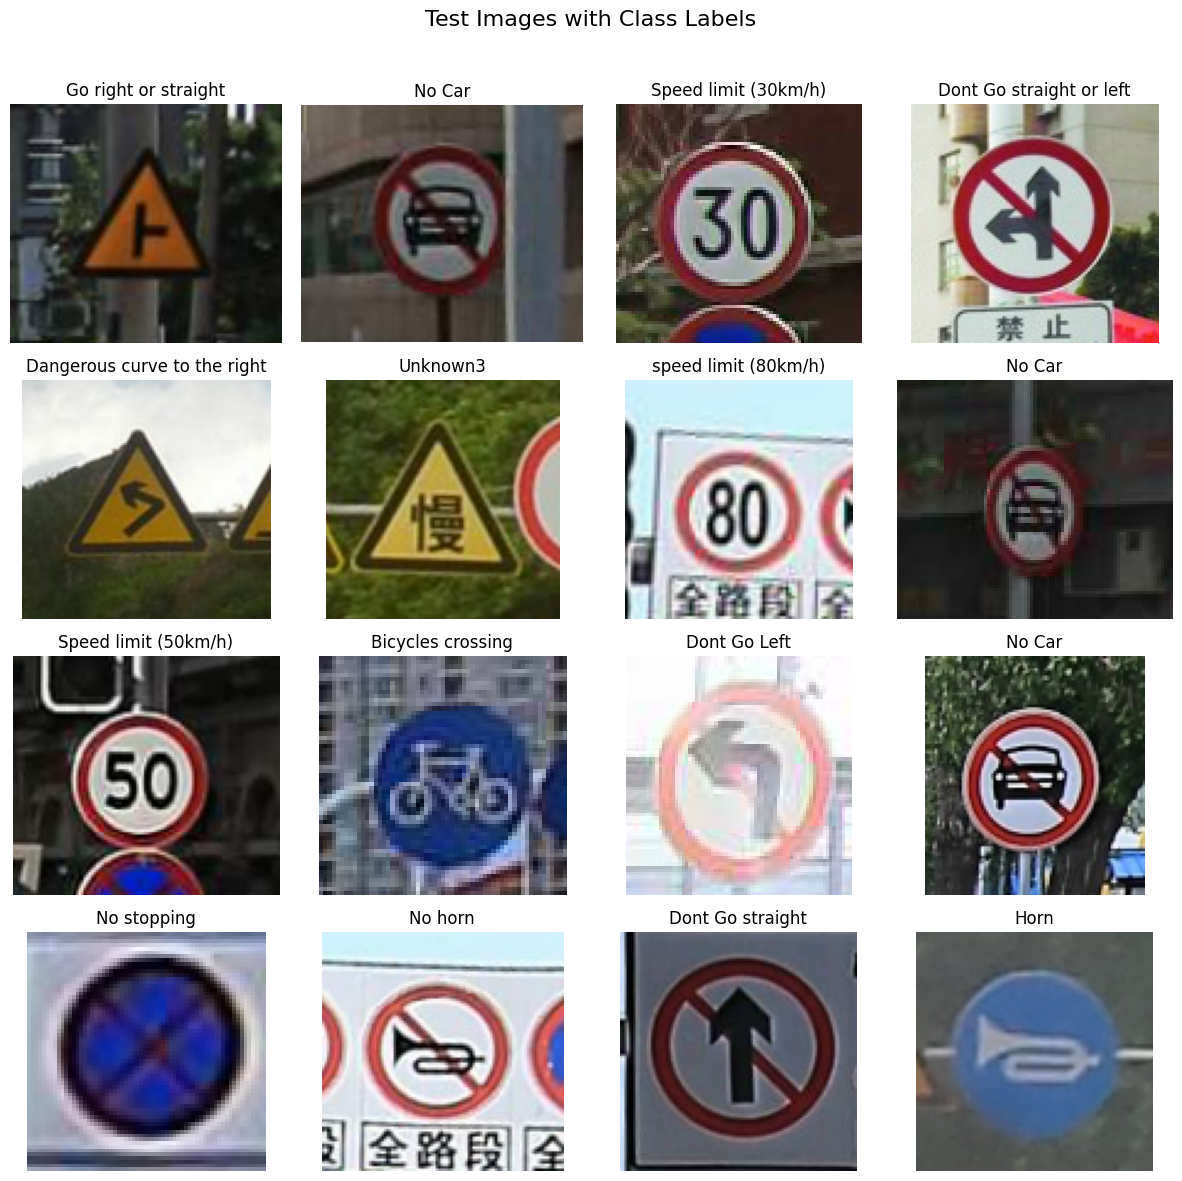

In [ ]:
import os
import pandas as pd

test_path = '/content/traffic_Data/TEST'
label_map_path = '/content/labels.csv'

class_map = pd.read_csv(label_map_path)

filenames = os.listdir(test_path)

data = []
for fname in filenames:
    class_id_str = fname.split('_')[0]
    if class_id_str.isdigit():
        class_id = int(class_id_str)
        data.append({'filename': fname, 'class': class_id})

test_df = pd.DataFrame(data)

merged_df = test_df.merge(class_map, left_on='class', right_on='ClassId')
merged_df.head()

import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Test Images with Class Labels", fontsize=16)

for i, ax in enumerate(axes.flat):
    row = merged_df.iloc[i]
    img_path = os.path.join(test_path, row['filename'])
    img = Image.open(img_path).convert("RGB")

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(row['Name'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
train_path = '/content/traffic_Data/DATA'

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class TestTrafficDataset(Dataset):
    def __init__(self, img_dir, transform, label_map):
        self.img_dir = img_dir
        self.transform = transform
        self.filenames = os.listdir(img_dir)
        self.label_map = label_map

        self.data = []
        for fname in self.filenames:
            class_id = int(fname.split('_')[0])
            self.data.append((fname, class_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fname, label = self.data[idx]
        img_path = os.path.join(self.img_dir, fname)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, label

In [ ]:
test_path = '/content/traffic_Data/TEST'
label_map = pd.read_csv('/content/labels.csv')

test_dataset = TestTrafficDataset(test_path, transform, label_map)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class TrafficCNN(nn.Module):
    def __init__(self, num_classes=58):
        super(TrafficCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),

            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficCNN(num_classes=58).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = 100 * correct / len(train_dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss:.4f} Accuracy: {accuracy:.2f}%")

Epoch [1/100] Loss: 54.3913 Accuracy: 87.10%
Epoch [2/100] Loss: 50.7834 Accuracy: 88.03%
Epoch [3/100] Loss: 48.2607 Accuracy: 88.44%
Epoch [4/100] Loss: 48.5563 Accuracy: 88.47%
Epoch [5/100] Loss: 46.2042 Accuracy: 88.99%
Epoch [6/100] Loss: 44.1792 Accuracy: 89.74%
Epoch [7/100] Loss: 40.6505 Accuracy: 90.24%
Epoch [8/100] Loss: 39.2707 Accuracy: 90.65%
Epoch [9/100] Loss: 37.9938 Accuracy: 90.94%
Epoch [10/100] Loss: 38.5585 Accuracy: 90.96%
Epoch [11/100] Loss: 32.3495 Accuracy: 92.16%
Epoch [12/100] Loss: 30.7851 Accuracy: 92.95%
Epoch [13/100] Loss: 33.2673 Accuracy: 91.94%
Epoch [14/100] Loss: 31.0156 Accuracy: 92.83%
Epoch [15/100] Loss: 28.7619 Accuracy: 93.05%
Epoch [16/100] Loss: 27.8234 Accuracy: 93.45%
Epoch [17/100] Loss: 28.3796 Accuracy: 93.41%
Epoch [18/100] Loss: 24.6321 Accuracy: 93.79%
Epoch [19/100] Loss: 28.1540 Accuracy: 93.45%
Epoch [20/100] Loss: 26.9743 Accuracy: 93.50%
Epoch [21/100] Loss: 25.6183 Accuracy: 93.81%
Epoch [22/100] Loss: 24.9268 Accuracy: 94.2

In [ ]:
model.eval()

TrafficCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=128, out_features=58, bias=True)
  )
)

In [ ]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.01905717151454363


In [ ]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

1.0


In [ ]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(1)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 1.91%
